# Importar as bibliotecas

In [51]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna.samplers import TPESampler
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import hydroeval as he
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap

In [4]:
# Parâmetros para reprodutibilidade
np.random.seed(42)

# Obtenção dos Dados

In [5]:
df_2018 = pd.read_csv ('data/series_temporais_tratadas_2018.csv').drop(['Unnamed: 0'],axis=1)
df_2019 = pd.read_csv ('data/series_temporais_tratadas_2019.csv').drop(['Unnamed: 0'],axis=1)
df_2020 = pd.read_csv ('data/series_temporais_tratadas_2020.csv').drop(['Unnamed: 0'],axis=1)
df_2021 = pd.read_csv ('data/series_temporais_tratadas_2021.csv').drop(['Unnamed: 0'],axis=1)
df_2022 = pd.read_csv ('data/series_temporais_tratadas_2022.csv').drop(['Unnamed: 0'],axis=1)
df_2023 = pd.read_csv ('data/series_temporais_tratadas_2023.csv').drop(['Unnamed: 0'],axis=1)

# Funções auxiliares

## Objective function of Random Forest for Optuna

In [6]:
#Define an objective function to be minimized
def objective(trial):
  # Setup values for the hyperparameters:
  n_estimators = trial.suggest_int("n_estimators", low = 50, high = 200, step = 50)
  max_depth = trial.suggest_int("max_depth", low = 2, high = 20, step = 1)
  min_samples_split = trial.suggest_int("min_samples_split", low = 2, high = 20, step = 1)
  min_samples_leaf = trial.suggest_int("min_samples_leaf", low = 2, high = 20, step = 1)

  regressor = RandomForestRegressor(n_jobs=-1,verbose=0,max_depth=max_depth, n_estimators=n_estimators,min_samples_split=min_samples_split,min_samples_leaf = min_samples_leaf, random_state = 42)

  #Scoring method:
  regressor.fit(X_train, y_train)
  from sklearn.metrics import mean_squared_error as mse
  # getting forecasts for the test set
  predictions = regressor.predict(X_val)
  # computing MSE error
  mse = mse(predictions, y_val)
  rmse = np.sqrt(mse)
  score = rmse
  return score

def run_optuna(n_trials=50):
  # Run Optuna
  sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
  study = optuna.create_study(direction="minimize",sampler=sampler)
  #optuna.logging.set_verbosity(optuna.logging.INFO)
  optuna.logging.set_verbosity(optuna.logging.WARNING) #essa linha suprime o print das infos
  study.optimize(objective, n_trials=n_trials)
  trial = study.best_trial
  #print('RMSE: {}'.format(trial.value))
  #print("Best hyperparameters: {}".format(trial.params))
  #optuna.visualization.plot_optimization_history(study)
  #optuna.visualization.plot_slice(study)
  n_estimators = trial.params['n_estimators']
  max_depth = trial.params['max_depth']
  min_samples_split = trial.params['min_samples_split']
  min_samples_leaf = trial.params['min_samples_leaf']
  return trial, n_estimators, max_depth, min_samples_split, min_samples_leaf

## Objective Function of XGBoost for Optuna

In [7]:
#Define an objective function to be minimized
def objective_xgb(trial):
  # Setup values for the hyperparameters:
  # Adapted from https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
  params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0,log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0,log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0,log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0,log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0,log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0,log=True),
        'eval_metric': 'rmse'
    }

  regressor = xgb.XGBRegressor(objective = "reg:squarederror",random_state = 42,**params)
  regressor.fit(X_train, y_train)
  #Scoring method:
  from sklearn.metrics import mean_squared_error as mse
  # getting forecasts for the test set
  predictions = regressor.predict(X_val)
  # computing MSE error
  mse = mse(predictions, y_val)
  rmse = np.sqrt(mse)
  score = rmse
  return score

def run_optuna_xgb(n_trials=50):
  # Run Optuna
  sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
  study = optuna.create_study(direction="minimize",sampler=sampler)
  optuna.logging.set_verbosity(optuna.logging.INFO)
  #optuna.logging.set_verbosity(optuna.logging.WARNING) #essa linha suprime o print das infos
  study.optimize(objective_xgb, n_trials=n_trials)
  trial = study.best_trial
  #print('RMSE: {}'.format(trial.value))
  #print("Best hyperparameters: {}".format(trial.params))
  #optuna.visualization.plot_optimization_history(study)
  #optuna.visualization.plot_slice(study)
  max_depth = trial.params['max_depth']
  learning_rate = trial.params['learning_rate']
  n_estimators = trial.params['n_estimators']
  min_child_weight = trial.params['min_child_weight']
  gamma = trial.params['gamma']
  subsample = trial.params['subsample']
  colsample_bytree = trial.params['colsample_bytree']
  reg_alpha = trial.params['reg_alpha']
  reg_lambda = trial.params['reg_lambda']
  return trial, max_depth, learning_rate , n_estimators, min_child_weight, gamma,subsample, colsample_bytree, reg_alpha, reg_lambda

## Fit e evaluate

In [8]:
def training_rf(X_train,y_train,random_state = 42):
    model = RandomForestRegressor(n_jobs=-1, verbose=0,random_state=random_state)
    model.fit(X_train, y_train.ravel())
    importances = model.feature_importances_
    return model, importances

def training_xgb(X_train, y_train,random_state = 42):
    model = xgb.XGBRegressor(objective="reg:squarederror",random_state=random_state)
    model.fit(X_train, y_train.ravel())
    importances = model.feature_importances_
    return model, importances

def training_lgb(X_train, y_train,random_state = 42):
    model = lgb.LGBMRegressor(objective = 'regression',metric='rmse',random_state=random_state,verbose = 0)
    model.fit(X_train, y_train.ravel())
    importances = model.feature_importances_
    return model, importances

def training_cb(X_train,y_train,random_state = 42):
    model = cb.CatBoostRegressor(loss_function='RMSE',random_state=random_state,verbose = 0)
    model.fit(X_train, y_train.ravel())
    importances = model.feature_importances_
    return model, importances


def predictions(X_train,y_train,X_val,y_val,model):
    prediction = model.predict(X_val)
    mse = mean_squared_error(prediction, y_val)
    rmse = np.sqrt(mse)
    nse = he.evaluator(he.nse, prediction, y_val)
    nse = nse[0]
    prediction_train = model.predict(X_train)
    mse_train = mean_squared_error(prediction_train, y_train)
    rmse_train = np.sqrt(mse_train)
    nse_train = he.evaluator(he.nse, prediction_train, y_train)
    nse_train = nse_train[0]

    # print("Root mean squared error (RMSE) on train set: {:.4f}".format(rmse_train))
    # print(f"Nash-Sutcliffe-Efficience (NSE) on train set: {nse_train}")
    # print("Root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
    # print(f"Nash-Sutcliffe-Efficience (NSE) on test set: {nse}")

    return prediction, rmse, nse


def plot_results(prediction,y_val,nse):
    plt.figure(figsize=(20, 10))
    plt.plot(prediction,color='orange',label='predicted')
    plt.plot(y_val,label='actual')
    plt.title(f'Actual and predicted river level at station 413 for the test set, NSE = {nse}',fontsize=18)
    plt.ylabel('River level (cm)',fontsize=14)
    plt.xlabel('Time stamp',fontsize=14)
    plt.legend()

    plt.figure(figsize=(6,6))
    plt.scatter(y_val, prediction, c='r',s=5)
    p1 = max(max(prediction), max(y_val))
    p2 = min(min(prediction), min(y_val))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('Actual', fontsize=15)
    plt.ylabel('Predicted', fontsize=15)
    plt.axis('equal')

## Time Delay Embedding

In [9]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Time delay embedding
    Time series for supervised learning
    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    X = [series.shift(i) for i in n_lags_iter]
    X = pd.concat(X, axis=1).dropna()
    X.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return X

## Preparação dos Conjuntos de Treinament/Validação/Teste

In [10]:
def preparar_dataframes(dataframes_treinamento, dataframes_validacao, dataframes_teste,horizon=12):
  # Conjunto de treinamento
  df_treinamento = pd.DataFrame()
  dataframes = dataframes_treinamento

  for df in dataframes:
    train = df
    train = train.set_index(['intervalo'])

    # create data set with lagged features using time delay embedding
    train_ds = []
    for col in train:
      col_df = time_delay_embedding(train[col], n_lags=12, horizon=horizon)
      train_ds.append(col_df)

    # Concatenating all variables
    train_df = pd.concat(train_ds, axis=1)

    df_treinamento = pd.concat([df_treinamento, train_df])
  train_df = df_treinamento

  # Conjunto de validação
  df_validacao = pd.DataFrame()
  dataframes = dataframes_validacao

  for df in dataframes:
    val = df
    val = val.set_index(['intervalo'])
    # create data set with lagged features using time delay embedding
    val_ds = []
    for col in val:
      col_df = time_delay_embedding(val[col], n_lags=12, horizon=horizon)
      val_ds.append(col_df)

    # Concatenating all variables
    val_df = pd.concat(val_ds, axis=1)

    df_validacao = pd.concat([df_validacao, val_df])
  val_df = df_validacao

  # Conjunto de teste
  test = df_2023
  test = test.set_index(['intervalo'])

  # create data set with lagged features using time delay embedding
  test_ds = []
  for col in test:
    col_df = time_delay_embedding(test[col], n_lags=12, horizon=horizon)
    test_ds.append(col_df)

  # Concatenating all variables
  test_df = pd.concat(test_ds, axis=1)

  return train_df, val_df, test_df

In [11]:
def gerar_conjuntos(train_df,val_df,test_df,horizon=12):
  # Treinamento - defining target (Y) and explanatory variables (X)
  predictor_variables = train_df.columns.str.contains('-')
  target_variables = train_df.columns.str.contains(f'valor_leitura_flu_413(t+{horizon}',regex=False)

  X_train = train_df.iloc[:, predictor_variables]
  y_train = train_df.iloc[:, target_variables]
  # Validação - defining target (Y) and explanatory variables (X)
  predictor_variables = val_df.columns.str.contains('-')
  target_variables = val_df.columns.str.contains(f'valor_leitura_flu_413(t+{horizon}',regex=False)

  X_val = val_df.iloc[:, predictor_variables]
  y_val = val_df.iloc[:, target_variables]
  # Teste - defining target (Y) and explanatory variables (X)
  predictor_variables = test_df.columns.str.contains('-')
  target_variables = train_df.columns.str.contains(f'valor_leitura_flu_413(t+{horizon}',regex=False)

  X_test = test_df.iloc[:, predictor_variables]
  y_test = test_df.iloc[:, target_variables]

  return X_train,y_train,X_val,y_val,X_test,y_test

## Plot importâncias

In [44]:
def plot_importances(importances,feature_names,n_features_show):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 4))
    plt.title("Feature importances")
    plt.bar(range(n_features_show), importances[indices[0:n_features_show]],
            color="b", align="center")
    plt.xticks(range(n_features_show), feature_names[indices[0:n_features_show]], rotation='vertical')
    plt.xlim([-1, n_features_show])

# Experimentos

# Primeira comparação entre RF, XGB, LGB, CB

## Exp. 5 - Markoviano (com treino em 2018/2019 e validação em 2020)

In [52]:
train_df, val_df, test_df = preparar_dataframes(dataframes_treinamento = [df_2018, df_2019], dataframes_validacao = [df_2020], dataframes_teste = [df_2023])
X_train_general,y_train_general,X_val_general,y_val_general,X_test_general,y_test_general = gerar_conjuntos(train_df,val_df,test_df)

In [53]:
entradas = []
entradas.append('valor_leitura_flu_413(t-0)')
X_train_general.columns
for nome in X_train_general.columns:
  if ('plu' in nome and '-0' in nome):
    entradas.append(nome)


X_train = np.array(X_train_general[entradas])
X_val = np.array(X_val_general[entradas])
X_test = np.array(X_test_general[entradas])
y_train = np.array(y_train_general.values)
y_val = np.array(y_val_general.values)
y_test = np.array(y_test_general.values)

In [54]:
feature_names = X_train_general[entradas].columns

Average of RMSE: 44.58802231531906
Average of NSE: 0.8098126842417253


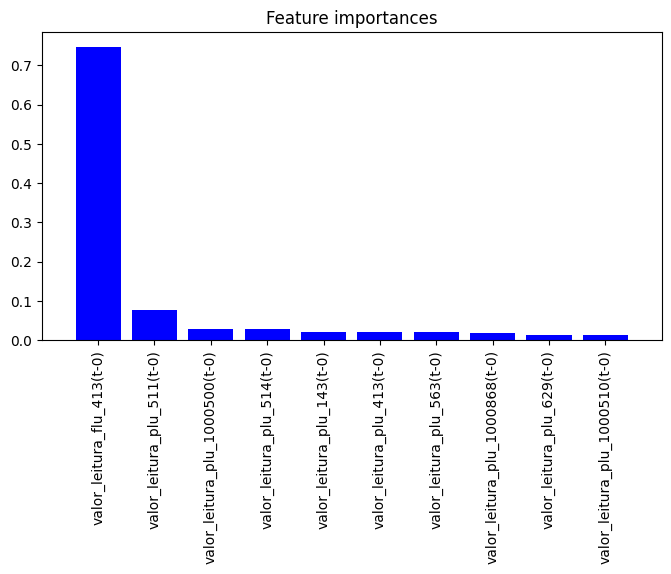

In [55]:
# Random Forest
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_rf(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)
plot_importances(importances,feature_names,n_features_show = 10)

In [56]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_val)

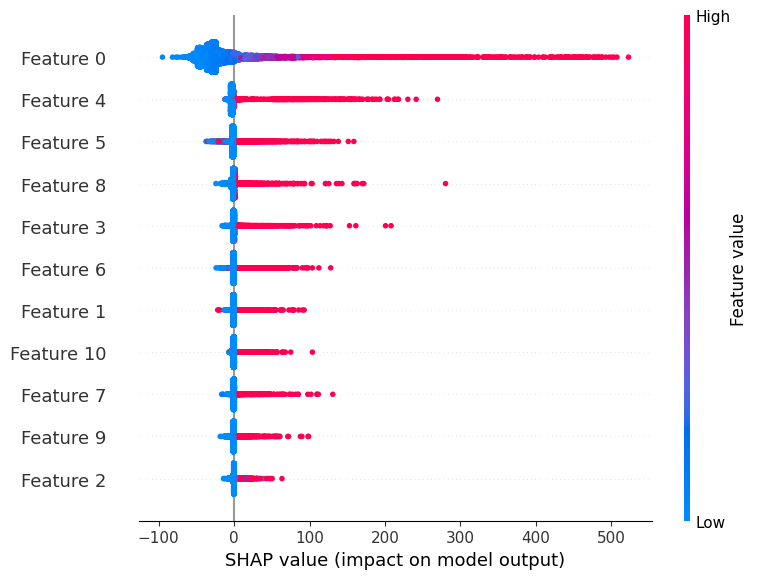

In [57]:
shap.summary_plot(shap_values, X_val)

In [87]:
# XGBoost
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_xgb(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)
plot_importances(importances,feature_names,n_features_show = 10)

Average of RMSE: 44.39246427709734
Average of NSE: 0.8114773060407817


In [88]:
# LightGBM
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_lgb(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)
plot_importances(importances,feature_names,n_features_show = 10)

Average of RMSE: 43.24613544179031
Average of NSE: 0.8210878899795528


In [89]:
# CatBoost
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_cb(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)
plot_importances(importances,feature_names,n_features_show = 10)

Average of RMSE: 42.8902341262595
Average of NSE: 0.8240205470785541


## Exp. 5 - Com lag features (com treino em 2018/2019 e validação em 2020)

### Usando todas as features

In [40]:
train_df, val_df, test_df = preparar_dataframes(dataframes_treinamento = [df_2018, df_2019], dataframes_validacao = [df_2020], dataframes_teste = [df_2023])
X_train_general,y_train_general,X_val_general,y_val_general,X_test_general,y_test_general = gerar_conjuntos(train_df,val_df,test_df)

entradas = []
X_train_general.columns
for nome in X_train_general.columns:
  if ('plu' in nome) or ('valor_leitura_flu_413' in nome):
    entradas.append(nome)

X_train_general = X_train_general[entradas]
X_val_general = X_val_general[entradas]
X_test_general = X_test_general[entradas]

X_train = np.array(X_train_general)
X_val = np.array(X_val_general)
X_test = np.array(X_test_general)
y_train = np.array(y_train_general.values).ravel()
y_val = np.array(y_val_general.values).ravel()
y_test = np.array(y_test_general.values).ravel()

In [41]:
feature_names = X_train_general.columns

Average of RMSE: 41.86234669179653
Average of NSE: 0.8323543575265766


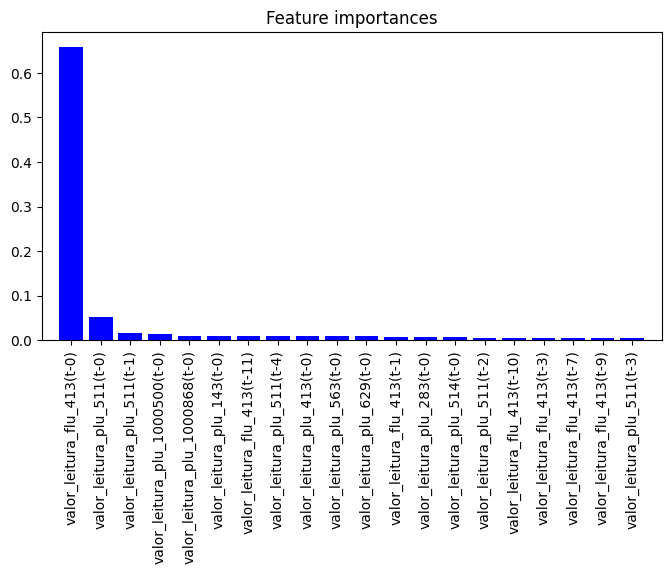

In [46]:
# Random Forest
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_rf(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)
plot_importances(importances,feature_names,n_features_show = 20)

Average of RMSE: 41.49677372371826
Average of NSE: 0.8352695841905309


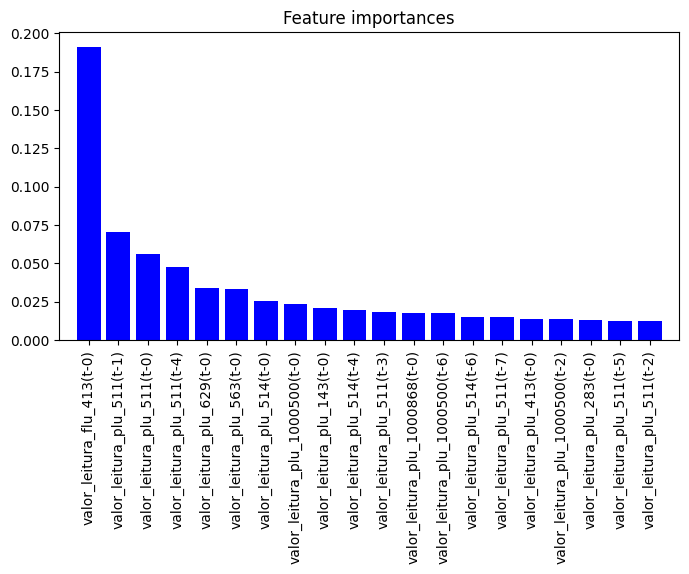

In [48]:
# XGBoost
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_xgb(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)
plot_importances(importances,feature_names,n_features_show = 20)

Average of RMSE: 40.22019440446573
Average of NSE: 0.8452490013851117


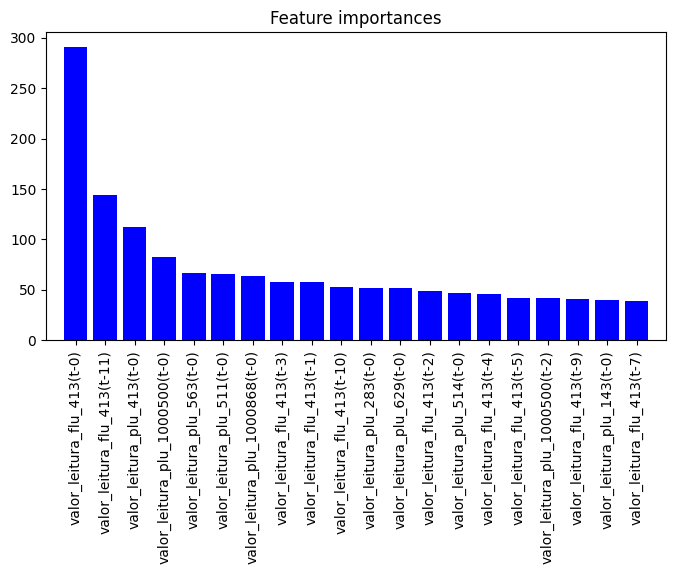

In [49]:
# LightGBM
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_lgb(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)
plot_importances(importances,feature_names,n_features_show = 20)

Average of RMSE: 39.40096291510712
Average of NSE: 0.8514889390681348


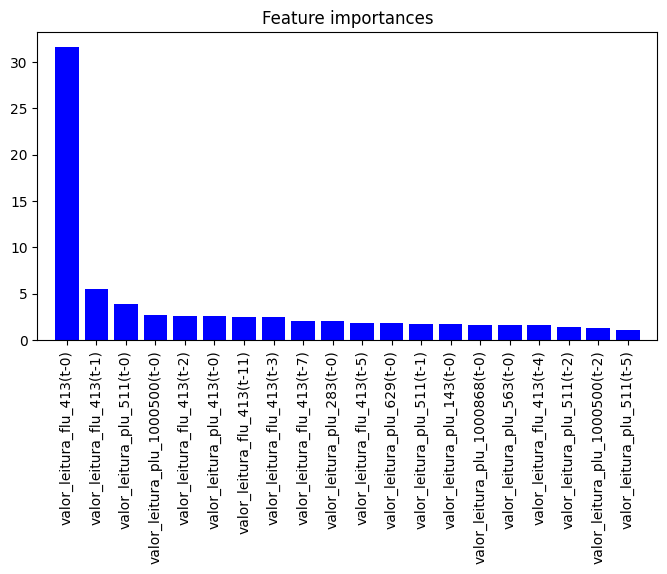

In [50]:
# CatBoost
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_cb(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)
plot_importances(importances,feature_names,n_features_show = 20)

# Análise da Capacidade Preditiva de Estações

## Experimento Markoviano para ver se alguém supera o Experimento 5

In [12]:
train_df, val_df, test_df = preparar_dataframes(dataframes_treinamento = [df_2018, df_2019], dataframes_validacao = [df_2020], dataframes_teste = [df_2023])
X_train_general,y_train_general,X_val_general,y_val_general,X_test_general,y_test_general = gerar_conjuntos(train_df,val_df,test_df)


entradas = []
X_train_general.columns
for nome in X_train_general.columns:
  if ('-0' in nome):
    entradas.append(nome)

X_train = np.array(X_train_general[entradas])
X_val = np.array(X_val_general[entradas])
X_test = np.array(X_test_general[entradas])
y_train = np.array(y_train_general.values)
y_val = np.array(y_val_general.values)
y_test = np.array(y_test_general.values)

In [22]:
feature_names = X_train_general[entradas].columns

'valor_leitura_flu_143(t-0)'

In [14]:
# Random Forest
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_rf(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)

Average of RMSE: 45.742899640908476
Average of NSE: 0.7998329856037234


(-1.0, 10.0)

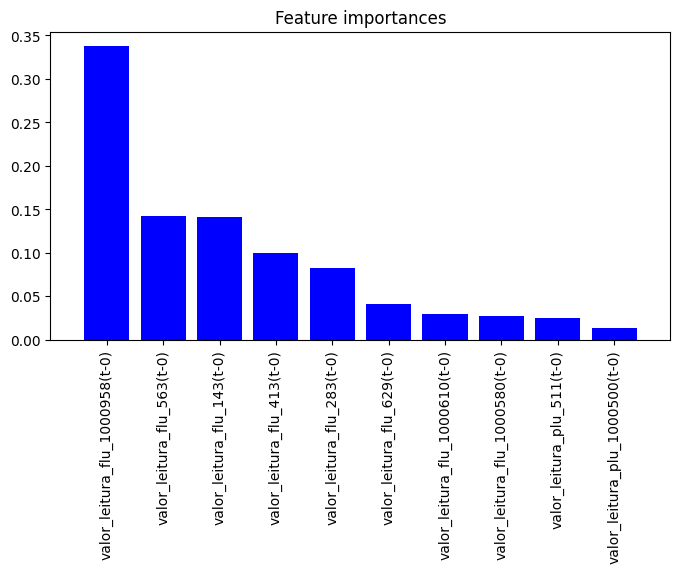

In [26]:
indices = np.argsort(importances)[::-1]

# Plota o gráfico de barras com os nomes das features
plt.figure(figsize=(8, 4))
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]],
        color="b", align="center")
plt.xticks(range(10), feature_names[indices[0:10]], rotation='vertical')
plt.xlim([-1, 10])

## Experimento com todos os lags para ver se alguém supera o Experimento 5

In [28]:
train_df, val_df, test_df = preparar_dataframes(dataframes_treinamento = [df_2018, df_2019], dataframes_validacao = [df_2020], dataframes_teste = [df_2023])
X_train_general,y_train_general,X_val_general,y_val_general,X_test_general,y_test_general = gerar_conjuntos(train_df,val_df,test_df)

X_train = np.array(X_train_general)
X_val = np.array(X_val_general)
X_test = np.array(X_test_general)
y_train = np.array(y_train_general.values)
y_val = np.array(y_val_general.values)
y_test = np.array(y_test_general.values)

In [29]:
feature_names = X_train_general.columns

In [30]:
# Random Forest
rmse_mean = 0
nse_mean = 0
total_iter = 1
for i in range(total_iter):
    model, importances = training_rf(X_train,y_train)
    prediction, rmse, nse = predictions(X_train,y_train,X_val,y_val,model)
    #plot_results(prediction,y_val,nse)
    rmse_mean += rmse
    nse_mean += nse
rmse_mean = rmse_mean/total_iter
nse_mean = nse_mean/total_iter
print('Average of RMSE:', rmse_mean)
print('Average of NSE:',nse_mean)

Average of RMSE: 44.06298579297038
Average of NSE: 0.814265331820194


In [ ]:
indices = np.argsort(importances)[::-1]

n_features_show = 20

# Plota o gráfico de barras com os nomes das features
plt.figure(figsize=(8, 4))
plt.title("Feature importances")
plt.bar(range(n_features_show), importances[indices[0:n_features_show]],
        color="b", align="center")
plt.xticks(range(n_features_show), feature_names[indices[0:n_features_show]], rotation='vertical')
plt.xlim([-1, n_features_show])